In [1]:
from osgeo import gdal, ogr

import fiona

import numpy as np
import pandas as pd
import geopandas as gpd
import cartopy as cart
import matplotlib as mpl
import cartopy.crs as ccrs
import cmcrameri.cm as cmc
import matplotlib.pyplot as plt
from datetime import datetime
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap

from fiona.drvsupport import supported_drivers

supported_drivers['LIBKML'] = 'rw'
plt.rcParams.update({'font.size': 10, 'font.weight' : 'bold'})

In [2]:
data_path = "/Users/opodriscoll/Documents/Scripts/ORCESTRA/S1_acquisition/data/"
data_file = "S1A_MP_USER_20240816T174000_20240904T194000.kml"
data_file = "S1A_MP_USER_20240828T174000_20240917T194000.kml"
data_file = "S1A_MP_USER_20240903T174000_20240923T194000.kml"
data_file = "S1A_MP_USER_20240910T174000_20240930T194000.kml"

In [3]:
fp=data_path + data_file 

gdf_list = []
for layer in fiona.listlayers(fp):    
    gdf = gpd.read_file(fp, driver='LIBKML', layer=layer)
    gdf_list.append(gdf)

gdf = gpd.GeoDataFrame(pd.concat(gdf_list, ignore_index=True))

gdf.head()

,Name,description,timestamp,begin,end,altitudeMode,tessellate,extrude,visibility,drawOrder,...,SatelliteId,DatatakeId,Mode,Swath,Polarisation,ObservationTimeStart,ObservationTimeStop,ObservationDuration,OrbitAbsolute,OrbitRelative
0,2024-09-10T17:46:01,None,NaT,2024-09-10 17:46:01,2024-09-10 17:46:34,None,-1,0,-1,None,...,S1A,6C9BD,EW,NA,DH,2024-09-10T17:46:01,2024-09-10T17:46:34,33,55606,59
1,2024-09-10T17:46:45,None,NaT,2024-09-10 17:46:45,2024-09-10 17:47:40,None,-1,0,-1,None,...,S1A,6C9BE,IW,NA,DH,2024-09-10T17:46:45,2024-09-10T17:47:40,55,55606,59
2,2024-09-10T17:47:50,None,NaT,2024-09-10 17:47:50,2024-09-10 17:51:05,None,-1,0,-1,None,...,S1A,6C9BF,EW,NA,DH,2024-09-10T17:47:50,2024-09-10T17:51:05,194,55606,59
3,2024-09-10T17:54:49,None,NaT,2024-09-10 17:54:49,2024-09-10 17:55:38,None,-1,0,-1,None,...,S1A,6C9C0,EW,NA,DH,2024-09-10T17:54:49,2024-09-10T17:55:38,49,55606,59
4,2024-09-10T18:03:02,None,NaT,2024-09-10 18:03:02,2024-09-10 18:03:18,None,-1,0,-1,None,...,S1A,6C9C1,IW,NA,DV,2024-09-10T18:03:02,2024-09-10T18:03:18,17,55606,59


In [4]:
# date in string format
str_start = "03-09-2024 00:00:00"
str_end = "23-09-2024 00:00:00"

# convert to datetime instance
dt_start = datetime.strptime(str_start, "%d-%m-%Y %H:%M:%S")
dt_end = datetime.strptime(str_end, "%d-%m-%Y %H:%M:%S")
N_days = (dt_end-dt_start).days

condition = (gdf["begin"] >= dt_start) & (gdf["begin"] <= dt_end)
gdf_filt = gdf[condition]

gdf_filt.head()

,Name,description,timestamp,begin,end,altitudeMode,tessellate,extrude,visibility,drawOrder,...,SatelliteId,DatatakeId,Mode,Swath,Polarisation,ObservationTimeStart,ObservationTimeStop,ObservationDuration,OrbitAbsolute,OrbitRelative
0,2024-09-10T17:46:01,None,NaT,2024-09-10 17:46:01,2024-09-10 17:46:34,None,-1,0,-1,None,...,S1A,6C9BD,EW,NA,DH,2024-09-10T17:46:01,2024-09-10T17:46:34,33,55606,59
1,2024-09-10T17:46:45,None,NaT,2024-09-10 17:46:45,2024-09-10 17:47:40,None,-1,0,-1,None,...,S1A,6C9BE,IW,NA,DH,2024-09-10T17:46:45,2024-09-10T17:47:40,55,55606,59
2,2024-09-10T17:47:50,None,NaT,2024-09-10 17:47:50,2024-09-10 17:51:05,None,-1,0,-1,None,...,S1A,6C9BF,EW,NA,DH,2024-09-10T17:47:50,2024-09-10T17:51:05,194,55606,59
3,2024-09-10T17:54:49,None,NaT,2024-09-10 17:54:49,2024-09-10 17:55:38,None,-1,0,-1,None,...,S1A,6C9C0,EW,NA,DH,2024-09-10T17:54:49,2024-09-10T17:55:38,49,55606,59
4,2024-09-10T18:03:02,None,NaT,2024-09-10 18:03:02,2024-09-10 18:03:18,None,-1,0,-1,None,...,S1A,6C9C1,IW,NA,DV,2024-09-10T18:03:02,2024-09-10T18:03:18,17,55606,59


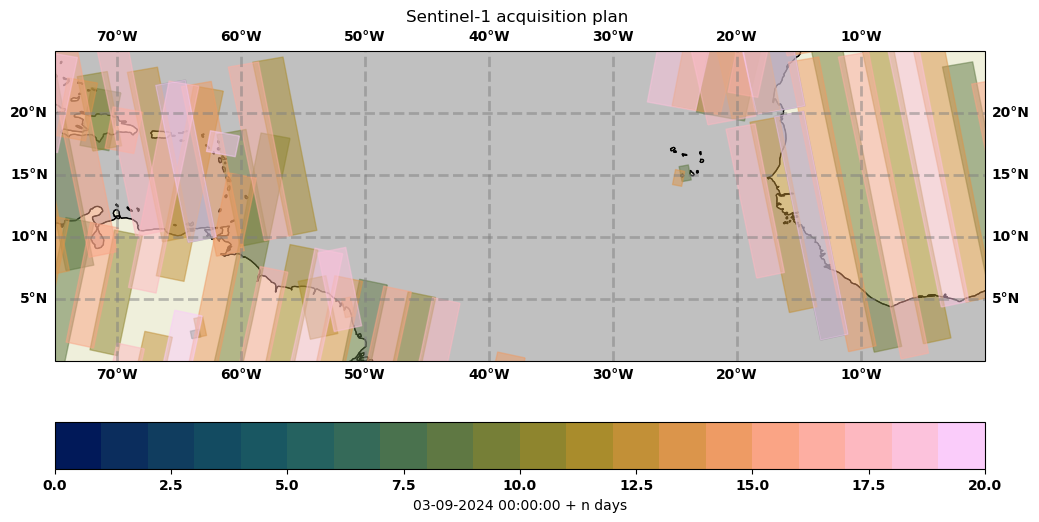

In [8]:
cmap_steps = N_days + 1
bounds = [-75., 0., 0., 25.]
proj = ccrs.PlateCarree()
figsize = (12, 8)
labelpad = 0.1
colormap = cmc.batlow

fig, ax= plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=figsize, subplot_kw={'projection': proj})
ax.set_extent(bounds, crs=proj)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.75)


discrete_cmap = colormap(np.linspace(0, 1, cmap_steps - 1))
cmap = ListedColormap(discrete_cmap)
norm = mpl.colors.Normalize(vmin=0, vmax=N_days)

for i in range(len(gdf_filt.geometry)):
        # select individual 
        acquisition = gdf_filt.iloc[i]
        acq_geom = acquisition.geometry
        acq_day = (acquisition.begin-dt_start).days

        ax.add_geometries([acq_geom], crs=proj, edgecolor='black', alpha=0.5, color = cmap.colors[acq_day])

ax.add_feature(cart.feature.LAND,zorder=0, edgecolor='k')
ax.gridlines(crs=proj, draw_labels=True,linewidth=2, color='gray', alpha=0.5, linestyle='--')
ax.set_facecolor('silver')

fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
             ax=ax, orientation='horizontal', label= f"{str_start} + n days", pad=labelpad)
ax.set_title("Sentinel-1 acquisition plan ")
# cbar.ax.set_yticklabels(cbar_labels)
# cbar.ax.tick_params(labelsize=labelsize) 

plt.show()